# BA 775 - Business Analytics Toolbox
## H&M Personalized Fashion Recommendations EDA Practice Exercise Version



## Introduction

[H&M Personalized Fashion Recommendations](https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/overview)

Welcome to our H&M Exploratory Data Analysis notebook. Our focus is to explore the intricate patterns and insights within the H&M retail ecosystem, leveraging three key data sources: articles.csv, customers.csv, and transactions_train.csv. These files offer a comprehensive look at product metadata, customer demographics, and transactional history, respectively. Although our analysis is independent of the competition's scope to develop product recommendations, the insights gleaned here could provide a foundational understanding that is crucial for any advanced predictive modeling. Let's embark on this data exploration journey, unraveling the stories told by the data through the powerful lens of SQL.

#Preparation

## Download the Kaggle Dataset

In [ ]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

from google.colab import auth
auth.authenticate_user()

To speed things up, we'll download the dataset directly from the course bucket into your personal bucket. Otherwise, you would need to create a Kaggle API key, download the dataset from Kaggle, and then upload it to your bucket, which takes longer.

In [ ]:
your_bucket = 'YOUR_BUCKET'

In [ ]:
!gsutil -m cp gs://ba-775-public/data/h_and_m/articles.csv gs://$your_bucket/data/h_and_m/
!gsutil -m cp gs://ba-775-public/data/h_and_m/sample_submission.csv gs://$your_bucket/data/h_and_m/
!gsutil -m cp gs://ba-775-public/data/h_and_m/customers.csv gs://$your_bucket/data/h_and_m/
!gsutil -m cp gs://ba-775-public/data/h_and_m/transactions_train.csv gs://$your_bucket/data/h_and_m/

Copying gs://ba-775-public/data/h_and_m/articles.csv [Content-Type=text/csv]...
Copying gs://ba-775-public/data/h_and_m/sample_submission.csv [Content-Type=text/csv]...
Copying gs://ba-775-public/data/h_and_m/customers.csv [Content-Type=text/csv]...
Copying gs://ba-775-public/data/h_and_m/transactions_train.csv [Content-Type=text/csv]...
\ [4/4 files][  3.7 GiB/  3.7 GiB] 100% Done                                    
Operation completed over 4 objects/3.7 GiB.                                      


Verify the files were uploaded successfully:

In [ ]:
!gsutil ls -lh gs://$your_bucket/data/h_and_m/

 34.45 MiB  2025-11-09T20:42:20Z  gs://ba-775/data/h_and_m/articles.csv
197.54 MiB  2025-11-09T20:42:20Z  gs://ba-775/data/h_and_m/customers.csv
257.76 MiB  2025-11-09T20:42:20Z  gs://ba-775/data/h_and_m/sample_submission.csv
  3.25 GiB  2025-11-09T20:42:21Z  gs://ba-775/data/h_and_m/transactions_train.csv
TOTAL: 4 objects, 4001546060 bytes (3.73 GiB)


Create a new dataset (schema) called `h_and_m`:

**Important note for Colab users:** Include ` --project=PROJECT_ID` for every SQL cell.

In [ ]:
%%bigquery
CREATE SCHEMA IF NOT EXISTS h_and_m

Query is running:   0%|          |

""


Create 3 tables from the 3 csv files: `articles.csv`, `customers.csv`, and `transactions_train.csv`.

Make sure to replace **YOUR_BUCKET** with your bucket name:

In [ ]:
%%bigquery
LOAD DATA OVERWRITE h_and_m.articles
FROM FILES (
  format = 'CSV',
  uris = ['gs://YOUR_BUCKET/data/h_and_m/articles.csv']
);

Query is running:   0%|          |

""


In [ ]:
%%bigquery
LOAD DATA OVERWRITE h_and_m.customers
FROM FILES (
  format = 'CSV',
  uris = ['gs://YOUR_BUCKET/data/h_and_m/customers.csv']
);

Query is running:   0%|          |

""


We'll save `transactions_train.csv` as `transactions`:

In [ ]:
%%bigquery
LOAD DATA OVERWRITE h_and_m.transactions
FROM FILES (
  format = 'CSV',
  uris = ['gs://YOUR_BUCKET/data/h_and_m/transactions_train.csv']
);

Query is running:   0%|          |

""


Since `transactions` table has over 31 million rows (and almost 3GB) we will create a random sample of approximately 1% of this table and work with that during our initial exploration to save cost and improve performance:

In [ ]:
%%bigquery
CREATE OR REPLACE TABLE h_and_m.transactions_sample
AS
SELECT * FROM h_and_m.transactions
WHERE MOD(ABS(FARM_FINGERPRINT(customer_id)),100) = 1

Query is running:   0%|          |

""


## Initial Inspection
Let's print out three rows of entries for each of the tables so we can have a rough idea what each table looks like.

### Print out 3 rows of the entries for `articles`

In [ ]:
%%bigquery
# YOUR CODE HERE

Query is running:   0%|          |

Downloading:   0%|          |

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,448831026,448831,Tom Solid,59,Swimwear bottom,Swimwear,1010016,Solid,63,Dark Purple,...,Swimwear,F,Menswear,3,Menswear,26,Men Underwear,1018,Swimwear,Short swim shorts with an elasticated drawstri...
1,510264001,510264,Carl covered,59,Swimwear bottom,Swimwear,1010005,Colour blocking,63,Dark Purple,...,Swimwear,F,Menswear,3,Menswear,26,Men Underwear,1018,Swimwear,Short swim shorts with an elasticated drawstri...
2,566941026,566941,Tom solid,59,Swimwear bottom,Swimwear,1010016,Solid,20,Other Yellow,...,Swimwear,F,Menswear,3,Menswear,26,Men Underwear,1018,Swimwear,Swim shorts in woven fabric with an elasticate...


### Print out 3 rows of the entries for `customers`

In [ ]:
%%bigquery
SELECT * FROM h_and_m.customers LIMIT 3

Downloading: 100%|██████████| 3/3 [00:01<00:00,  2.45rows/s]


,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,09a3dd9b174ce39cdfe1e8b5ec47167c8cc604928eec20...,1.0,1.0,PRE-CREATE,Monthly,65,b97439bfd3a833f9ef16537af6693c07493646d57b6191...
1,1608504257feb3b38b3700a081e12d2b1901c9b7d9be6d...,1.0,1.0,PRE-CREATE,Monthly,66,8fc2e6694f5b0fe6bcd212965cd9024e333e6c65473caf...
2,1e033264a3b552fe88bdcce44174dff8b4cfc58dad529c...,1.0,1.0,ACTIVE,Monthly,77,2df2189d6fefc69255504d4640f44adc849bd899bc2a3c...


### Print out 3 rows of the entries for `transactions_sample`

In [ ]:
%%bigquery
SELECT * FROM h_and_m.transactions_sample LIMIT 3

Downloading: 100%|██████████| 3/3 [00:01<00:00,  2.07rows/s]


,t_dat,customer_id,article_id,price,sales_channel_id
0,2019-01-24,02354fba443ecfd9914e9f842fe8a61e7e367cf6dd7057...,189616001,0.016932,2
1,2019-01-24,02354fba443ecfd9914e9f842fe8a61e7e367cf6dd7057...,571706001,0.022017,2
2,2019-01-24,02354fba443ecfd9914e9f842fe8a61e7e367cf6dd7057...,571706001,0.022017,2


## Basic Exercises

### WHERE

Write a query to find all transactions from the `transactions_sample` table for the date `2019-01-24` whose `price` is above 0.02. Select the columns `customer_id`, `article_id`, and `price` in your result.

In [ ]:
%%bigquery

# YOUR CODE HERE

Query is running:   0%|          |

Downloading:   0%|          |

,customer_id,article_id,price
0,02354fba443ecfd9914e9f842fe8a61e7e367cf6dd7057...,571706001,0.022017
1,02354fba443ecfd9914e9f842fe8a61e7e367cf6dd7057...,571706001,0.022017
2,023c2ece3f5ab273c693a88300951320d47949cda63f11...,732690002,0.067780
3,023c2ece3f5ab273c693a88300951320d47949cda63f11...,639976002,0.040661
4,023c2ece3f5ab273c693a88300951320d47949cda63f11...,732690002,0.067780
...,...,...,...
263,f7972f791a628d6b292a99af32c3d30726e5a6771fdd44...,689389015,0.021593
264,f7972f791a628d6b292a99af32c3d30726e5a6771fdd44...,764132001,0.036000
265,f8a8c5d26ea8dd1471c2008215cdd55e04ca4650166308...,529008010,0.021424
266,fd438ed451591c6d2d4787ad9150bd2d62e5d0c7acaec9...,650500003,0.059305


### GROUP BY

Write a query to calculate the total sales for each `article_id` on `2019-01-24` in the `transactions_sample` table. Display the `article_id` and the sum of `price` as `total_sales`.

In [ ]:
%%bigquery

# YOUR CODE HERE


Query is running:   0%|          |

Downloading:   0%|          |

,article_id,total_sales
0,189616001,0.016932
1,571706001,0.044034
2,732690002,0.135559
3,639976002,0.040661
4,699996001,0.050831
...,...,...
417,529008010,0.021424
418,635190001,0.015237
419,650500003,0.059305
420,675864001,0.016932


### ORDER BY

Write a query to sort the above query by total_sales in decending order.

In [ ]:
%%bigquery

# YOUR CODE HERE

Query is running:   0%|          |

Downloading:   0%|          |

,article_id,total_sales
0,639357001,0.152525
1,752228002,0.135576
2,732690002,0.135559
3,674071001,0.135559
4,677999001,0.127068
...,...,...
417,706268011,0.003390
418,670279001,0.003373
419,649059001,0.003373
420,355569002,0.003373


### HAVING

Write a query to find customers from the `customer` table who have an `age `greater than 30 and are classified as `ACTIVE` in the `club_member_status`. Display their number of purchases and filter on those who have made more than 2 purchases.

In [ ]:
%%bigquery

# YOUR CODE HERE
# HINT: USE SELECT, FROM, JOIN, WHERE, GROUP BY, HAVING in this order




Query is running:   0%|          |

Downloading:   0%|          |

,customer_id,purchase_count
0,027b812641c14bdc9bafd9575d504b48afac18f52e05cb...,11
1,002b600e482167e5994a88e644b987652e62d3e903a356...,9
2,0144fe339069df448e1a493e62db6758710efc49bc612d...,3
3,034eec0d431754924dd4f6810b5921ce5afbbc9255beae...,23
4,03c7a6c2b565d30be5d3f986229f063f7cdf05407aed9b...,79
...,...,...
5399,aa2c672baf12d91640ecd0a3060f0b3297d5380d369532...,84
5400,c0741a2ba4d99346044d153c5d82ac0eedd33b80277cea...,19
5401,d75bd94cc872b5afbca521b787ac4a4bc74480a8642ffd...,8
5402,db6dc2df13ee34d904594c6725435714f84b837283458e...,21


### WITH

Create a query using a WITH clause to establish a Common Table Expression (CTE) named `CustomerSpending`. This CTE should calculate the total spending for each customer from the `transactions_sample` table. Use the `WHERE` clause to filter for customers with a total spending greater than 0.1.

In [ ]:
%%bigquery

# YOUR CODE HERE
# Hint: WITH xxxx AS() then write your select


Query is running:   0%|          |

Downloading:   0%|          |

,customer_id,total_spending
0,02354fba443ecfd9914e9f842fe8a61e7e367cf6dd7057...,1.080610
1,023c2ece3f5ab273c693a88300951320d47949cda63f11...,3.554966
2,031467b574c674387defb341d582cf9e61c4463f976e5c...,4.399068
3,0646d5c722f7e81d38dbb09cec94c1decac5f81a949eda...,2.385797
4,0750dbd1ff615d93d8ba80e121b73e196a0aab7acd51cd...,2.010475
...,...,...
9740,86397bc55879ccded07b3ec0fa60c3f28978add488b613...,0.144017
9741,8bbb4b9ca3da0ed79958d4264282a38a30dff05c10ac00...,0.413169
9742,2da611d530899469add88571e0a6d67fae445abf5d3b99...,0.234797
9743,74c228cebc0a4a5ad7ff626cf8de950c4a1e1d5688e4a5...,0.152424


### Subqueries

Write a query to list all transactions from the `transactions_sample` table where the price of the article is higher than the average price of all articles sold on the same date `(2019-01-24)`. The query should use a subquery to determine the average price for that date. Select the `article_id`, `price`, and `t_dat` for each transaction that meets this condition.

In [ ]:
%%bigquery

# YOUR CODE HERE
# HINT: in your WHERE statement, make your price > (subquery)


Query is running:   0%|          |

Downloading:   0%|          |

,article_id,price,t_dat
0,732690002,0.067780,2019-01-24
1,639976002,0.040661,2019-01-24
2,732690002,0.067780,2019-01-24
3,699996001,0.050831,2019-01-24
4,664461002,0.030492,2019-01-24
...,...,...,...
209,733404001,0.033881,2019-01-24
210,682305001,0.050831,2019-01-24
211,764132001,0.036000,2019-01-24
212,650500003,0.059305,2019-01-24


### Window Function

EX1: Write a query to find the running total of sales for each day in the `transactions_sample` table. Display the transaction date (`t_dat`), article ID (`article_id`), individual price, and a new column named `running_total` that shows the total sum of sales for that day as you go down the rows. The transactions should be ordered by date (ASC) and `running_total` (DESC).

Hint:
Use the `SUM()` function with the OVER() clause to create a running total.

In [ ]:
%%bigquery

# YOUR CODE HERE


Query is running:   0%|          |

Downloading:   0%|          |

,t_dat,article_id,price,running_total
0,2018-09-20,660599001,0.033881,17.503780
1,2018-09-20,676990002,0.050831,17.503780
2,2018-09-20,579541001,0.016932,17.503780
3,2018-09-20,537346024,0.042356,17.503780
4,2018-09-20,537688014,0.050831,17.503780
...,...,...,...,...
317914,2020-09-22,214844001,0.001678,11.680847
317915,2020-09-22,689014016,0.042356,11.680847
317916,2020-09-22,759814009,0.033881,11.680847
317917,2020-09-22,706016019,0.033881,11.680847


EX2: Write a query to rank each customer's purchases by their price for transactions made on '2019-01-24'. Your result should include the customer's ID, the article they purchased, the price of the article, and a rank number with 1 representing their highest-priced purchase.

Hint: To rank something within groups in SQL, you can use the `RANK()` function in combination with `OVER()` and `PARTITION BY`.

In [ ]:
%%bigquery

#YOUR CODE HERE


Query is running:   0%|          |

Downloading:   0%|          |

,customer_id,article_id,price,price_rank
0,4e1c0f78971fa55a9926f3a8ae3d6421c3813c84178f61...,560270001,0.030492,1
1,4e1c0f78971fa55a9926f3a8ae3d6421c3813c84178f61...,700974001,0.022017,2
2,a6ab6cc0a5282014e7b0af4a2fe602d6d5c4b442021033...,665212005,0.022017,1
3,b60e0e7036663ebc5588bdd64772d7d3c653d89072f907...,537346022,0.013542,1
4,b60e0e7036663ebc5588bdd64772d7d3c653d89072f907...,373493008,0.008458,2
...,...,...,...,...
480,eac5a57f2257dfe5e5dc4803b6825ac2eaf9e9d2a81e43...,665410004,0.015237,3
481,93a5bb7c805fd6470c0f67c762937af0977e09a9be0173...,718906002,0.067780,1
482,93a5bb7c805fd6470c0f67c762937af0977e09a9be0173...,573085020,0.033881,2
483,93a5bb7c805fd6470c0f67c762937af0977e09a9be0173...,539291004,0.015237,3


## Exploring the `articles` table

###  Display some of the images

Total number of files in images:  105108


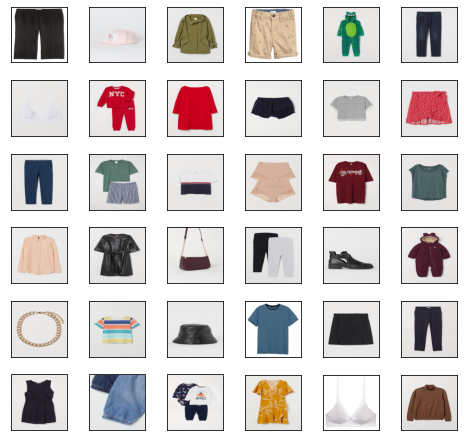

In [ ]:
filenames = []
for path, subdirs, files in os.walk('h-and-m-personalized-fashion-recommendations/images'):
    for name in files:
        filenames.append(os.path.join(path, name))
print('Total number of files in images: ', len(filenames))

random.seed(10)
sample_images = random.sample(filenames, 36)

fig, axes = plt.subplots(6, 6, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.4))

for i, ax in enumerate(axes.flat):
    ax.imshow(Image.open(sample_images[i]).resize((180, 180)))
    #ax.set_title(sample_images[i])

### How many unique articles/products/etc are in this table?


In [ ]:
%%bigquery

#YOUR CODE HERE

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.72s/rows]


,n_rows,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,...,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name
0,105542,105542,47224,45875,132,131,19,30,30,50,...,299,250,10,10,5,5,57,56,21,21


### Can you investigate and figure out what the difference between `article_id` and `product_code` is?

In [ ]:
%%bigquery

#YOUR CODE HERE

Downloading: 100%|██████████| 47224/47224 [00:01<00:00, 41226.29rows/s]


,product_code,n_articles
0,783707,75
1,684021,70
2,699923,52
3,699755,49
4,685604,46
...,...,...
47219,595949,1
47220,644071,1
47221,714373,1
47222,714376,1


### We're interested in the product_code 783707. Let's do some exploration:

Let's first find out the number of unique entries for rows with product_code 783707.

In [ ]:
%%bigquery

#YOUR CODE HERE

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.30s/rows]


,n_rows,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,...,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name
0,75,75,1,3,1,1,1,3,3,23,...,1,1,1,1,1,1,1,1,1,1


Then, can you use STRING_AGG and CAST to show the content of the distinct entries?

In [ ]:
%%bigquery
#YOUR CODE HERE

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.34s/rows]


,prod_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,n_detail_desc
0,"1pk Fun 1,1pk Fun,1pk fun sock","1010001,1010022,1010014","All over pattern,Jacquard,Placement print","82,63,83,62,6,7,8,9,10,13,19,21,32,33,42,52,61...","Turquoise,Dark Purple,Dark Turquoise,Purple,Li...",1


Let's now print out the corresponding graphs of the product.

In [ ]:
files_0783707 = !ls h-and-m-personalized-fashion-recommendations/images/078/0783707*
len(files_0783707)

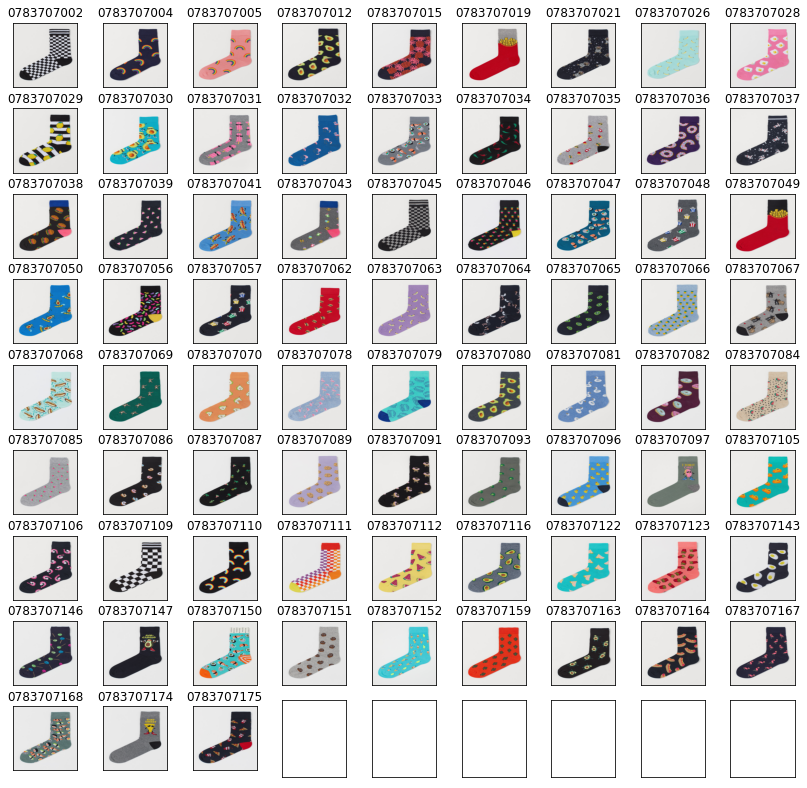

In [ ]:
fig, axes = plt.subplots(9, 9, figsize=(14, 14),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.4))

for i, ax in enumerate(axes.flat):
    ax.imshow(Image.open(files_0783707[i]).resize((180, 180)))
    ax.set_title(files_0783707[i][56:-4])
    if i == len(files_0783707)-1:
        break

### What is the breakdown of `index_name`?

In [ ]:
%%bigquery
#YOUR CODE HERE

Downloading: 100%|██████████| 10/10 [00:01<00:00,  7.29rows/s]


,index_name,n_articles
0,Ladieswear,26001
1,Divided,15149
2,Menswear,12553
3,Children Sizes 92-140,12007
4,Children Sizes 134-170,9214
5,Baby Sizes 50-98,8875
6,Ladies Accessories,6961
7,Lingeries/Tights,6775
8,"Children Accessories, Swimwear",4615
9,Sport,3392


### What is the breakdown of `index_group_name`?

In [ ]:
%%bigquery
#YOUR CODE HERE

Downloading: 100%|██████████| 5/5 [00:01<00:00,  3.86rows/s]


,index_group_name,n_articles,n_index_name,index_name,n_garment_group_name,garment_group_name
0,Ladieswear,39737,3,"Ladieswear,Lingeries/Tights,Ladies Accessories",18,"Unknown,Special Offers,Socks and Tights,Dresse..."
1,Baby/Children,34711,4,"Children Sizes 134-170,Children Sizes 92-140,B...",17,"Dresses/Skirts girls,Jersey Fancy,Trousers,Kni..."
2,Divided,15149,1,Divided,16,"Blouses,Dresses Ladies,Unknown,Outdoor,Jersey ..."
3,Menswear,12553,1,Menswear,16,"Swimwear,Accessories,Under-, Nightwear,Dressed..."
4,Sport,3392,1,Sport,5,"Outdoor,Jersey Fancy,Accessories,Unknown,Trousers"


### What is the breakdown of the combination for `index_group_name` and `garment_group_name`?





In [ ]:
%%bigquery
#YOUR CODE HERE

Downloading: 100%|██████████| 72/72 [00:01<00:00, 56.66rows/s]


,index_group_name,garment_group_name,n_articles
0,Baby/Children,Jersey Fancy,9103
1,Ladieswear,Jersey Fancy,6163
2,Ladieswear,Accessories,4999
3,Ladieswear,"Under-, Nightwear",4513
4,Ladieswear,Blouses,4492
...,...,...,...
67,Divided,Special Offers,148
68,Divided,Swimwear,76
69,Baby/Children,Unknown,59
70,Menswear,Special Offers,25


## Exploring the `customers` table

### What is the age demographic of the customers?

In [ ]:
%%bigquery
#YOUR CODE HERE

Downloading: 100%|██████████| 10/10 [00:01<00:00,  6.67rows/s]


,age,n_customers
0,10s,71583
1,20s,528358
2,30s,234068
3,40s,204118
4,50s,226242
5,60s,72623
6,70s,17611
7,80s,1415
8,90s,101
9,Unknown,15861


## Exploring the `transactions` table

Find out the date for the first and the latest transactions

In [ ]:
%%bigquery
#YOUR CODE HERE

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.45s/rows]


,f0_,f1_
0,2018-09-20,2020-09-22


Top 10 customers who purchased most often

In [ ]:
%%bigquery
#YOUR CODE HERE

Downloading: 100%|██████████| 10/10 [00:01<00:00,  6.98rows/s]


,customer_id,n_transactions
0,d80ed4ababfa96812e22b911629e6bcbf5093769051ea4...,1066
1,e3717b1d03c73d1cfd0f27ef09c32381aab5ca11c5aed9...,592
2,4e57c43d931e365659f756e5b173b79b9fdc8cbc6a5eab...,587
3,578e704b2c2fc32d93261b4be9d4797301518f653a9c17...,511
4,0d8e6c1ea7890ce90968f017361e439f4ea9091de795e9...,503
5,2d545e697d8cf36558c81eb56c1776cb30f893585ed21a...,479
6,66fc1a29a90f01fe4d9b5e6f00d3e6fc803a4b5ffafbc7...,475
7,392d4ed7fe2b4b6bdf61f4ef1b6f9b614ce7c7d8052c60...,456
8,6b5851409a9ca9c54033fea3c354b7277b369fc0e61775...,437
9,2fd690c02e3f0a1def03a331bfbb133f0d0790af4f013f...,437


Top 10 customers who spent the most

In [ ]:
%%bigquery
#YOUR CODE HERE

Downloading: 100%|██████████| 10/10 [00:01<00:00,  7.20rows/s]


,customer_id,revenue
0,d80ed4ababfa96812e22b911629e6bcbf5093769051ea4...,39.821627
1,0d8e6c1ea7890ce90968f017361e439f4ea9091de795e9...,21.904220
2,4e57c43d931e365659f756e5b173b79b9fdc8cbc6a5eab...,18.525424
3,e3717b1d03c73d1cfd0f27ef09c32381aab5ca11c5aed9...,18.267475
4,578e704b2c2fc32d93261b4be9d4797301518f653a9c17...,17.440424
5,9e6b6c5bfb5fa347204dbd93f51d84be5fa631a09226ff...,16.356339
6,419d24b577b25ebf4e60feb39ff0466e6d7752f8ba02d1...,15.557136
7,42fd70f36a393442030b07e9fbc74c9fe8aac1769be4b4...,14.417780
8,2fd690c02e3f0a1def03a331bfbb133f0d0790af4f013f...,14.283678
9,6d1d3142514e6376099fa031d1cf16b8fb7a40060d881e...,13.827407


Top 5 revenue generating `product_group_name`

In [ ]:
%%bigquery
#YOUR CODE HERE

Downloading: 100%|██████████| 5/5 [00:01<00:00,  3.33rows/s]


,product_group_name,revenue
0,Garment Upper body,3418.268915
1,Garment Lower body,2348.618763
2,Garment Full body,1266.220797
3,Swimwear,577.979271
4,Underwear,537.535017
